# 🗑️ E-Waste Image Classification -

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aniketredekar","key":"aace9d4896a37c20dba7ea69fb0acc24"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download akshat103/e-waste-image-dataset

Dataset URL: https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset
License(s): apache-2.0
e-waste-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip e-waste-image-dataset.zip -d e-waste-image-dataset

Archive:  e-waste-image-dataset.zip
replace e-waste-image-dataset/modified-dataset/test/Battery/battery_106.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
import os


data_dir = "e-waste-image-dataset/modified-dataset"
print("Root contains:\n", os.listdir(data_dir))


sample_subfolder = os.path.join(data_dir, "train")
print("\nContents inside train:\n", os.listdir(sample_subfolder)[:10])

Root contains:
 ['train', 'test', 'val']

Contents inside train:
 ['Mouse', 'Mobile', 'Television', 'Printer', 'Microwave', 'Battery', 'Player', 'Washing Machine', 'Keyboard', 'PCB']


In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

# Set paths for train, val, test directories
base_path = "e-waste-image-dataset/modified-dataset"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

# Load datasets
img_size = (128, 128)
batch_size = 32

train_ds = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Print class names
class_names = train_ds.class_names
print("\nClasses:", class_names)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.

Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


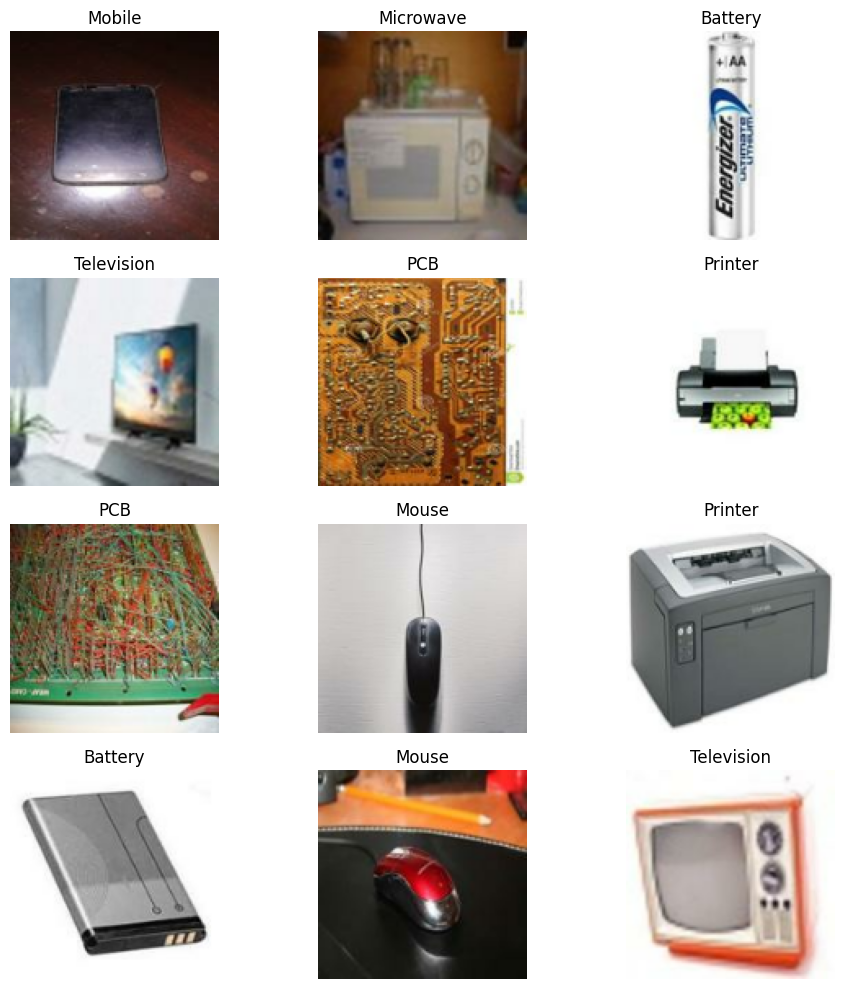

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.tight_layout()
plt.show()

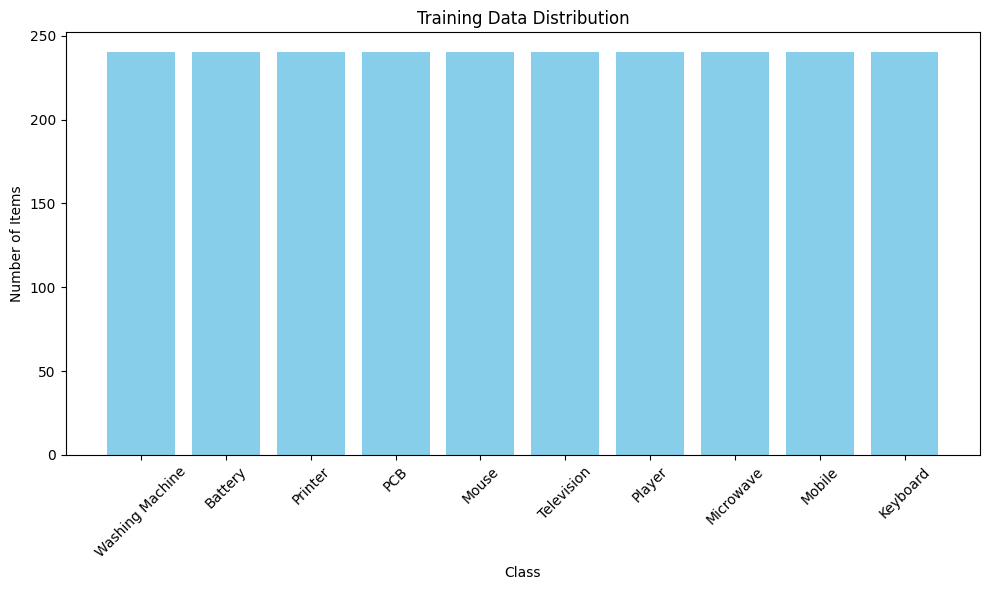

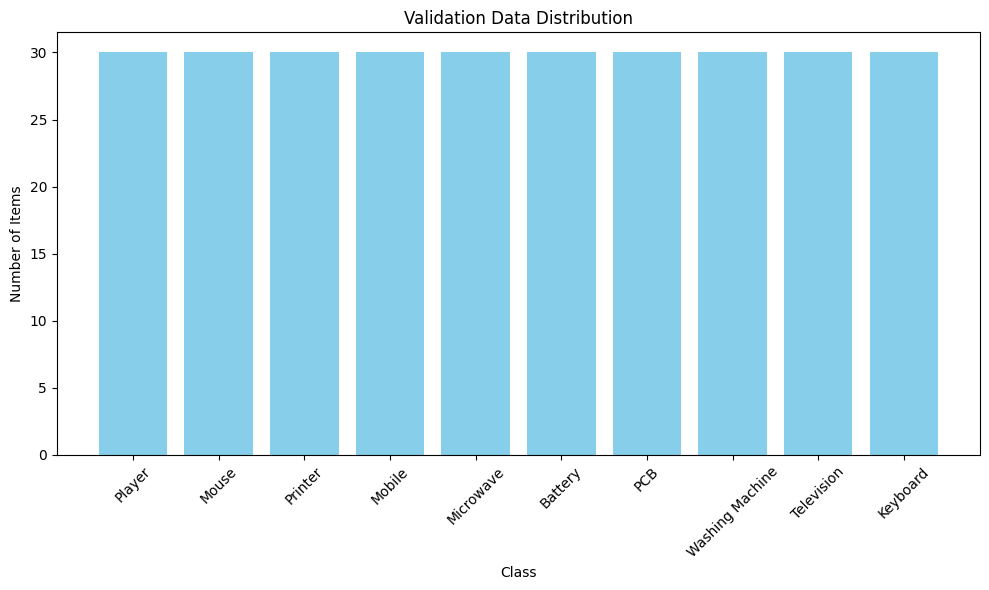

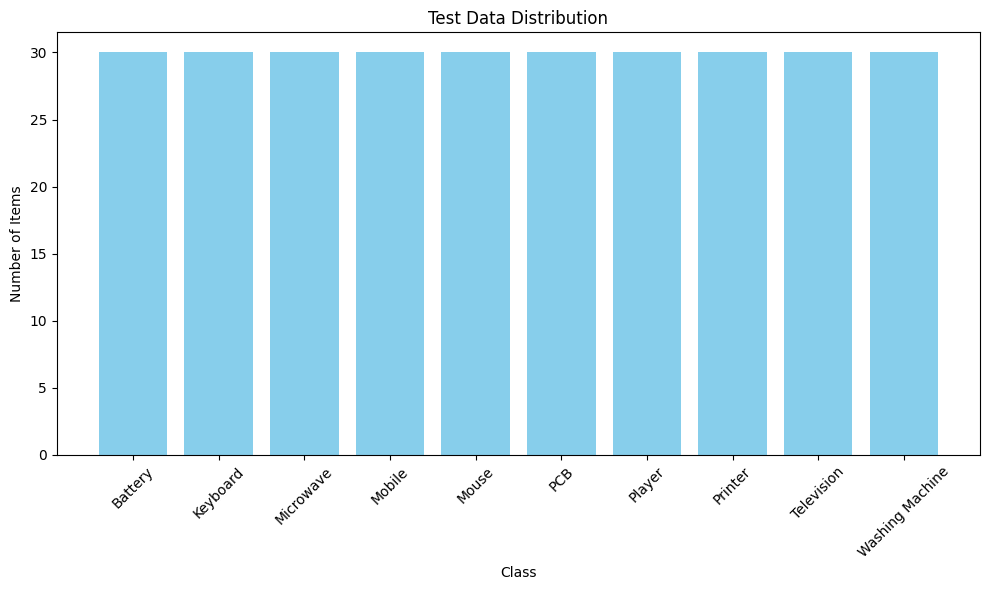

In [11]:
#Class distribution function + plots
def plot_class_distribution(dataset, title):
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_ds, "Training Data Distribution")
plot_class_distribution(val_ds, "Validation Data Distribution")
plot_class_distribution(test_ds, "Test Data Distribution")

In [12]:
#Data augmentation
import tensorflow as tf # Import the tensorflow library

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [13]:
#Base model selection
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [14]:
#Model creation
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [15]:
#Model compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['Accuracy']
)

In [16]:
#Early stopping
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:
#Train model
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=100,
    callbacks=[early]
)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - Accuracy: 0.2511 - loss: 2.1493 - val_Accuracy: 0.7567 - val_loss: 1.1338
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - Accuracy: 0.7518 - loss: 1.0421 - val_Accuracy: 0.9000 - val_loss: 0.5205
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Accuracy: 0.8659 - loss: 0.5271 - val_Accuracy: 0.9400 - val_loss: 0.3069
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - Accuracy: 0.9065 - loss: 0.3442 - val_Accuracy: 0.9533 - val_loss: 0.2133
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Accuracy: 0.9208 - loss: 0.2723 - val_Accuracy: 0.9600 - val_loss: 0.1837


In [19]:
#Evaluate model
import numpy as np
import seaborn as sns
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - Accuracy: 0.9367 - loss: 0.2016
Test accuracy is 0.9500, Test loss is 0.1792


In [23]:
#Confusion matrix + classification report
from sklearn.metrics import confusion_matrix, classification_report
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step
[[26  0  0  0  1  1  1  0  0  1]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  2  0  0  0 27  0  0  0]
 [ 0  0  0  0  0  1  0 29  0  0]
 [ 0  0  1  0  0  0  1  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       1.00      0.97      0.98        30
           2       0.91      0.97      0.94        30
           3       1.00      0.97      0.98        30
           4       0.97      0.97      0.97        30
           5       0.91      0.97      0.94        30
           6       0.90      0.90      0.90        30
           7       0.94      0.97      0.95        30
           8       1.00      0.93      0.97        30
           9       0.97      1.00      0.98        30

    accuracy                    

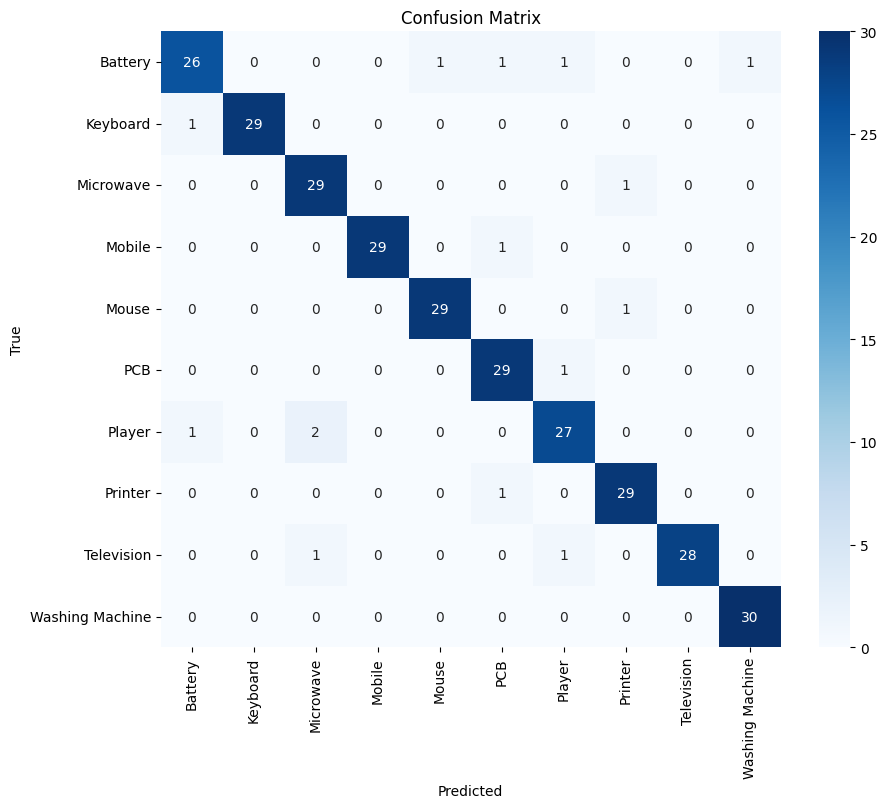

In [25]:
#Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

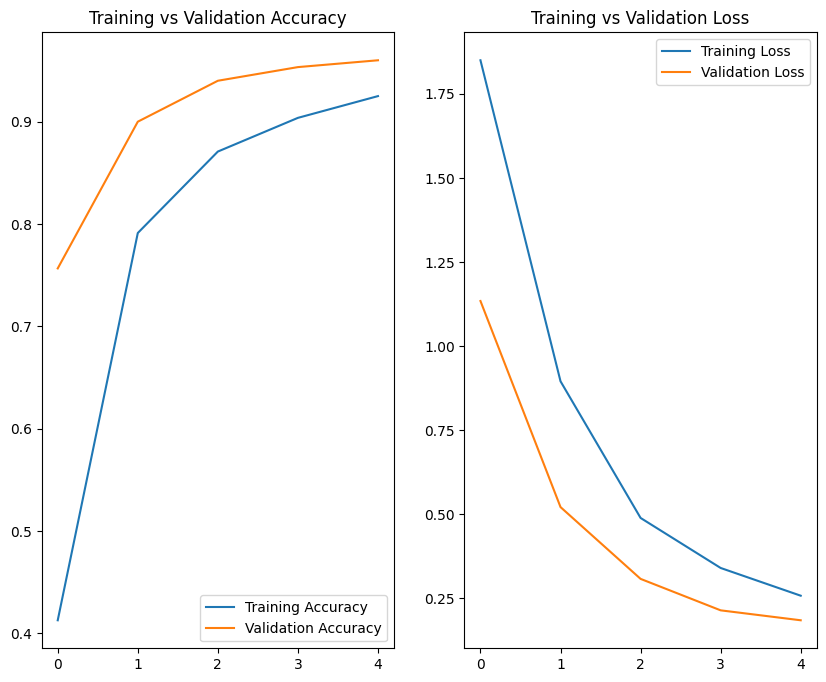

In [26]:
#Accuracy / loss trend plots
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()